# Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from datetime import timedelta
from sklearn.metrics import r2_score

# Load data

In [2]:
file_name = 'Super_Store_data.csv'
# Load the CSV file into a pandas DataFrame
furniture_store_data = pd.read_csv(file_name, encoding='ISO-8859-1')

# Display the first few rows of the DataFrame
print(furniture_store_data.head(10))

   Row ID        Order ID  Order Date   Ship Date       Ship Mode Customer ID  \
0       1  CA-2016-152156   11/8/2016  11/11/2016    Second Class    CG-12520   
1       2  CA-2016-152156   11/8/2016  11/11/2016    Second Class    CG-12520   
2       4  US-2015-108966  10/11/2015  10/18/2015  Standard Class    SO-20335   
3       6  CA-2014-115812    6/9/2014   6/14/2014  Standard Class    BH-11710   
4      11  CA-2014-115812    6/9/2014   6/14/2014  Standard Class    BH-11710   
5      24  US-2017-156909   7/16/2017   7/18/2017    Second Class    SF-20065   
6      25  CA-2015-106320   9/25/2015   9/30/2015  Standard Class    EB-13870   
7      28  US-2015-150630   9/17/2015   9/21/2015  Standard Class    TB-21520   
8      30  US-2015-150630   9/17/2015   9/21/2015  Standard Class    TB-21520   
9      37  CA-2016-117590   12/8/2016  12/10/2016     First Class    GH-14485   

     Customer Name    Segment        Country             City  ...  \
0      Claire Gute   Consumer  United 

In [3]:
# Check for null values
null_values = furniture_store_data.isnull().sum()
print("Null values:")
print(null_values)

Null values:
Row ID           0
Order ID         0
Order Date       0
Ship Date        0
Ship Mode        0
Customer ID      0
Customer Name    0
Segment          0
Country          0
City             0
State            0
Postal Code      0
Region           0
Product ID       0
Category         0
Sub-Category     0
Product Name     0
Sales            0
Quantity         0
Discount         0
Profit           0
dtype: int64


In [4]:
# Check dimensions (number of rows and columns)
dimensions = furniture_store_data.shape
print("\nDimensions (rows, columns):")
print(dimensions)


Dimensions (rows, columns):
(2121, 21)


In [5]:
# Check data types of columns
data_types = furniture_store_data.dtypes
print("\nData types:")
print(data_types)


Data types:
Row ID             int64
Order ID          object
Order Date        object
Ship Date         object
Ship Mode         object
Customer ID       object
Customer Name     object
Segment           object
Country           object
City              object
State             object
Postal Code        int64
Region            object
Product ID        object
Category          object
Sub-Category      object
Product Name      object
Sales            float64
Quantity           int64
Discount         float64
Profit           float64
dtype: object


In [6]:
# Convert date columns to datetime type 
date_columns = ['Order Date', 'Ship Date']  
for column in date_columns:
    furniture_store_data[column] = pd.to_datetime(furniture_store_data[column])

# Visualise time series data

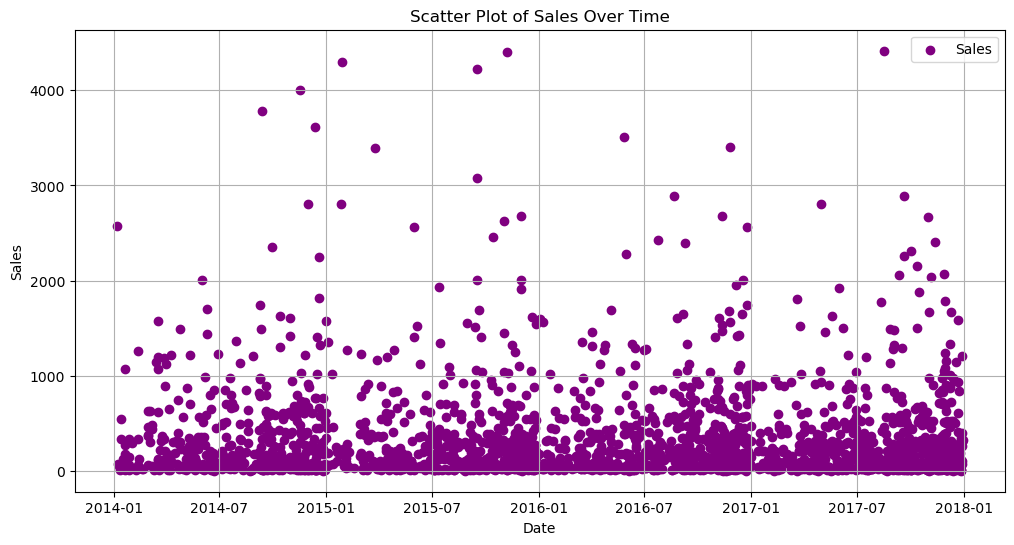

In [7]:
# Visualize time series data as a scatter plot
plt.figure(figsize=(12, 6))
plt.scatter(furniture_store_data['Order Date'], furniture_store_data['Sales'], label='Sales', color='purple')
plt.title('Scatter Plot of Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

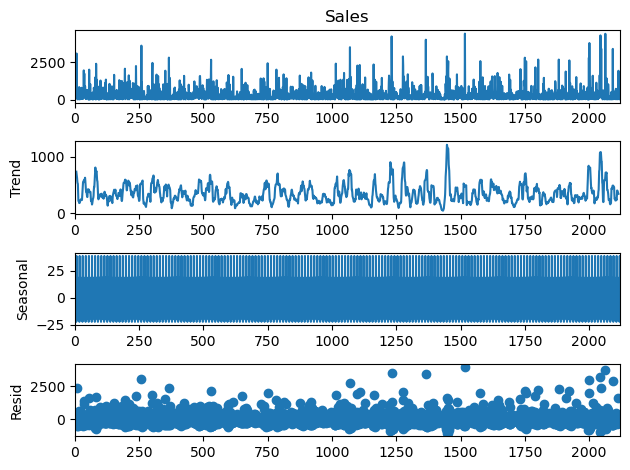

In [8]:
# Check for trends and seasonality
res = sm.tsa.seasonal_decompose(furniture_store_data['Sales'], period=12)  # Assuming seasonal period is 12 months
res.plot()
plt.show()

In [9]:
# Check for stationarity using Augmented Dickey-Fuller test
adf_test = sm.tsa.adfuller(furniture_store_data['Sales'])
print('ADF Statistic:', adf_test[0])
print('p-value:', adf_test[1])
print('Critical Values:', adf_test[4])

ADF Statistic: -23.778188911852272
p-value: 0.0
Critical Values: {'1%': -3.433441238483705, '5%': -2.862905584504915, '10%': -2.567496971789981}


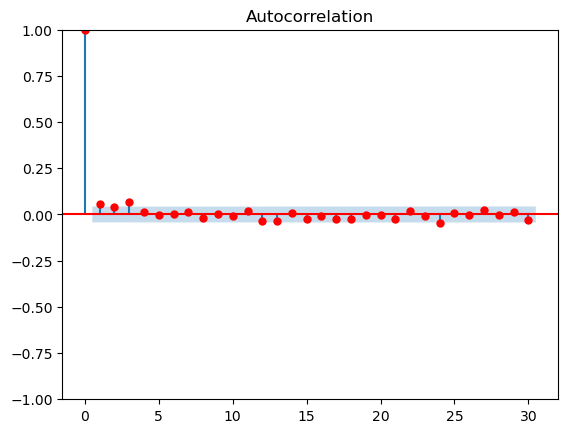

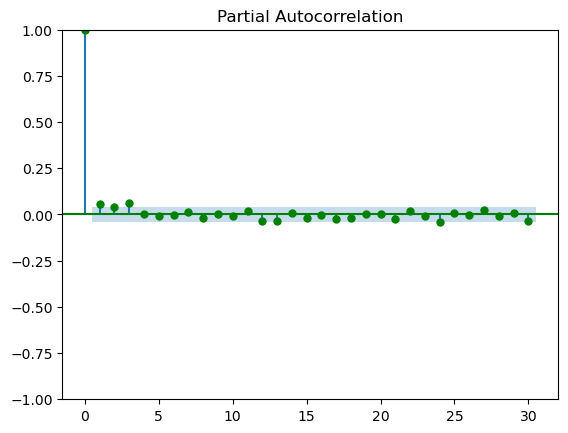

In [10]:
# Autocorrelation plot
sm.graphics.tsa.plot_acf(furniture_store_data['Sales'], lags=30, color = 'red')
plt.show()

# Partial autocorrelation plot
sm.graphics.tsa.plot_pacf(furniture_store_data['Sales'], lags=30, method='ywm', color = 'green')
plt.show()

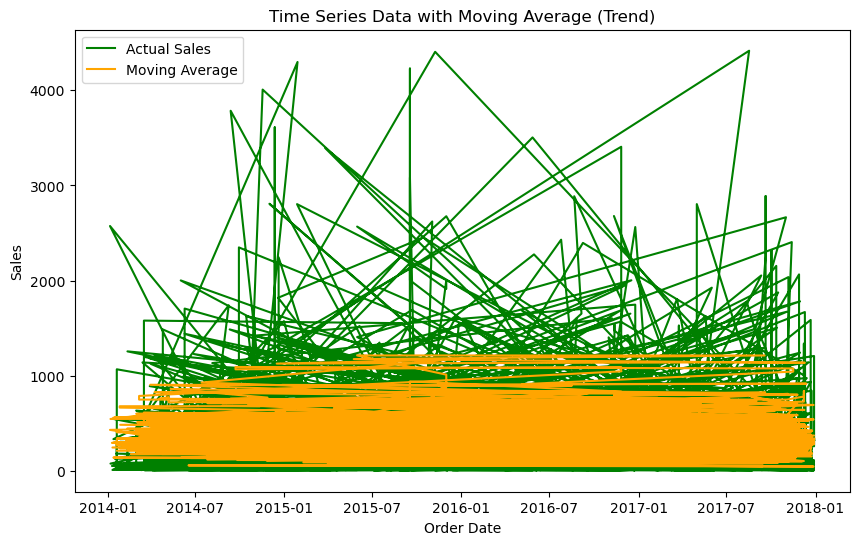

In [11]:
# Calculate the rolling mean (moving average) to detect trend
window_size = 12  
rolling_mean = furniture_store_data['Sales'].rolling(window=window_size).mean()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(furniture_store_data['Order Date'], furniture_store_data['Sales'], label='Actual Sales', color = 'green')
plt.plot(furniture_store_data['Order Date'], rolling_mean, label='Moving Average', color='orange')
plt.xlabel('Order Date')
plt.ylabel('Sales')
plt.title('Time Series Data with Moving Average (Trend)')
plt.legend()
plt.show()

# Forecasting models

In [12]:
# Set 'Order Date' as the index
furniture_store_data.set_index('Order Date', inplace=True)

# Resample data to monthly frequency and sum up sales for each month
monthly_sales = furniture_store_data['Sales'].resample('M').sum()

# Split data into train and test sets
train_size = int(len(monthly_sales) * 0.8)
train, test = monthly_sales[:train_size], monthly_sales[train_size:]

In [13]:
# ARIMA Model
def arima_forecast(train, test):
    history = [x for x in train]
    predictions = []
    for t in range(len(test)):
        model = ARIMA(history, order=(5,1,0))
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
    error = mean_squared_error(test, predictions)
    return predictions, error

In [14]:
# SARIMA Model
def sarima_forecast(train, test):
    history = [x for x in train]
    predictions = []
    for t in range(len(test)):
        model = SARIMAX(history, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
    error = mean_squared_error(test, predictions)
    return predictions, error

ARIMA Model MSE: 61181598.826447025


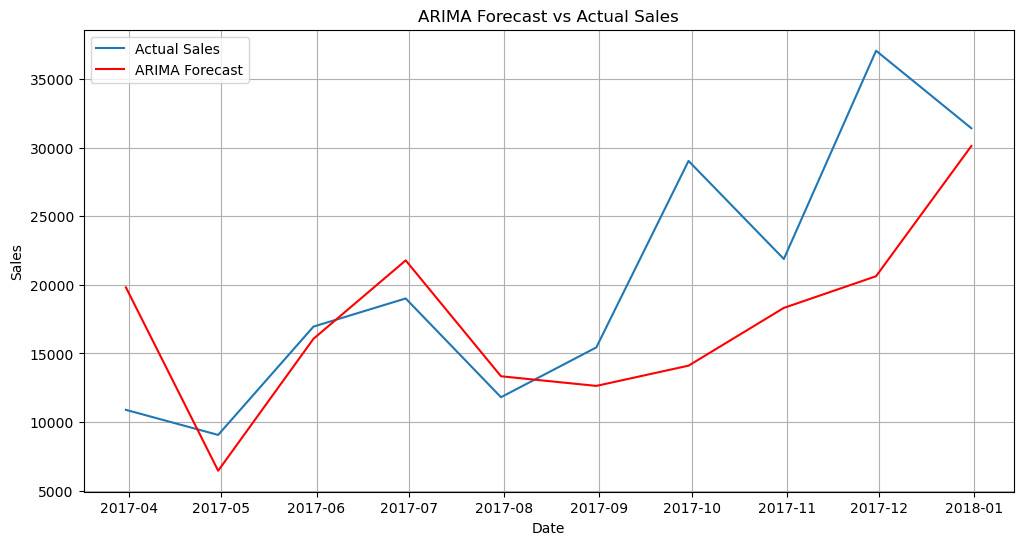

C:\Users\ABC\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA Model MSE: 22810683.045209683


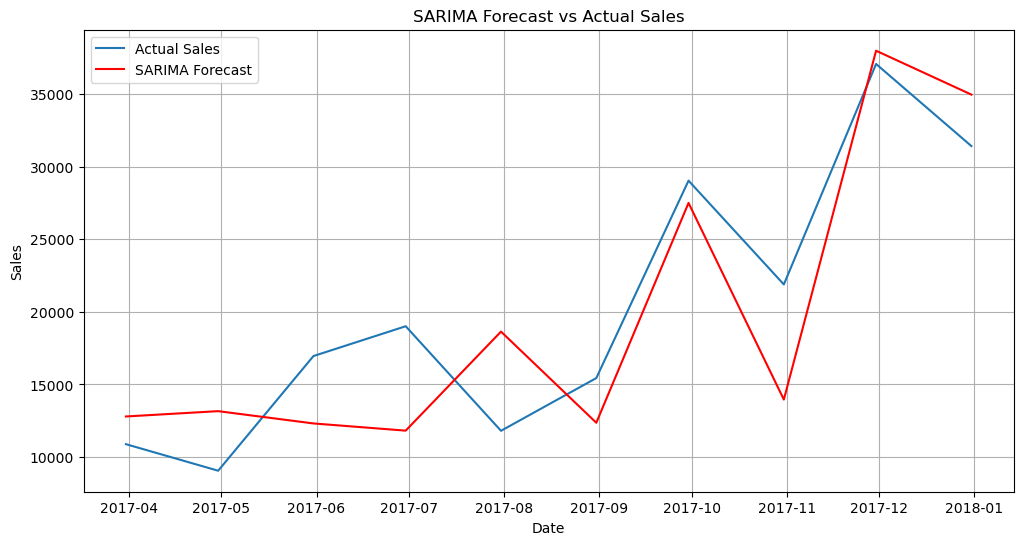

In [15]:
# Plot results
def plot_results(test, predictions, model_name):
    plt.figure(figsize=(12, 6))
    plt.plot(test.index, test, label='Actual Sales')
    plt.plot(test.index, predictions, color='red', label=f'{model_name} Forecast')
    plt.title(f'{model_name} Forecast vs Actual Sales')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    plt.grid(True)
    plt.show()
    
# ARIMA Forecast
arima_predictions, arima_error = arima_forecast(train, test)
print(f"ARIMA Model MSE: {arima_error}")
plot_results(test, arima_predictions, 'ARIMA')

# SARIMA Forecast
sarima_predictions, sarima_error = sarima_forecast(train, test)
print(f"SARIMA Model MSE: {sarima_error}")
plot_results(test, sarima_predictions, 'SARIMA')

In [16]:
# Calculate R2 score
def calculate_r2_score(test, predictions):
    return r2_score(test, predictions)

# ARIMA Model R2 score
arima_r2_score = calculate_r2_score(test, arima_predictions)
print("ARIMA Model R2 Score:", arima_r2_score)

# SARIMA Model R2 score
sarima_r2_score = calculate_r2_score(test, sarima_predictions)
print("SARIMA Model R2 Score:", sarima_r2_score)

ARIMA Model R2 Score: 0.24091495628605042
SARIMA Model R2 Score: 0.7169860110122985


In [17]:
# Generate timestamps for the forecasted periods
forecast_period = len(test)
forecast_start_date = test.index[0]
forecast_end_date = test.index[-1] + timedelta(days=30)  # Extend for a month
forecast_dates = pd.date_range(start=forecast_start_date, end=forecast_end_date, freq='M')

# Combine timestamps with predictions for ARIMA
arima_forecast_df = pd.DataFrame({'Date': forecast_dates, 'Predicted Sales (ARIMA)': arima_predictions})

# Combine timestamps with predictions for SARIMA
sarima_forecast_df = pd.DataFrame({'Date': forecast_dates, 'Predicted Sales (SARIMA)': sarima_predictions})

# Display the forecasted sales for both models
print("ARIMA Model Predicted Sales:")
print(arima_forecast_df)

print("\nSARIMA Model Predicted Sales:")
print(sarima_forecast_df)

ARIMA Model Predicted Sales:
        Date  Predicted Sales (ARIMA)
0 2017-03-31             19814.649130
1 2017-04-30              6458.535891
2 2017-05-31             16067.908174
3 2017-06-30             21782.177601
4 2017-07-31             13340.247859
5 2017-08-31             12637.977023
6 2017-09-30             14112.100955
7 2017-10-31             18320.279119
8 2017-11-30             20628.235256
9 2017-12-31             30117.047795

SARIMA Model Predicted Sales:
        Date  Predicted Sales (SARIMA)
0 2017-03-31              12798.674499
1 2017-04-30              13165.167669
2 2017-05-31              12319.433228
3 2017-06-30              11823.656263
4 2017-07-31              18639.484886
5 2017-08-31              12366.450241
6 2017-09-30              27494.610066
7 2017-10-31              13962.704116
8 2017-11-30              37968.906131
9 2017-12-31              34949.660694
